In [1]:
import sys
sys.path.append('..')
import config
from autoencoding import AutoEncoder

Using Theano backend.


In [2]:
import os
model_path = config.MODEL_PATH
model = AutoEncoder.from_h5(model_path)

../autoencoding.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/dense_1_i..., outputs=sigmoid.0)`
  output=model.layers[idx_code_layer].output)


In [14]:
train_dir = config.TRAIN_DIR
#train_dir = '../data/train2'
files = [os.path.join(train_dir, f) for f in os.listdir(train_dir)][:15000]

# Look at how well autoencoder predicts input

In [66]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_test_input(files, k=5):
    files = random.sample(files, k=k)
    return files, [np.load(f) * 2000 for f in files]

def compare_predictions(test_input, model, labels):
    plt.figure(figsize=(30, 30))
    f, axarr = plt.subplots(len(test_input), sharex=True, sharey=True)
    f.subplots_adjust(hspace=.5)
    for i, (X, L) in enumerate(zip(test_input, labels)):
        xshape = X.shape[0]
        y_hat = model.predict(X.reshape(1, xshape))
        axarr[i].plot(X)
        axarr[i].plot(y_hat.reshape((xshape,)), color='r')
        axarr[i].set_title(L, fontsize=8)

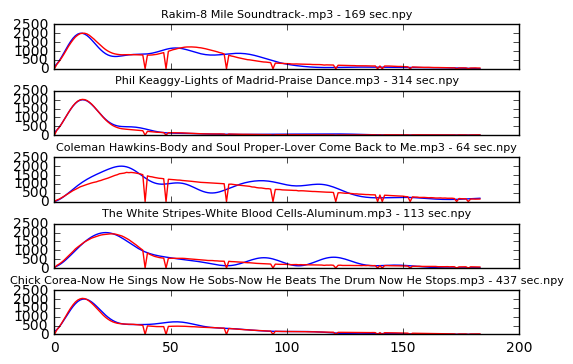

In [67]:
test_files, test_input = get_test_input(files)
compare_predictions(test_input, model, [os.path.basename(f) for f in test_files])

In [6]:
print(y_hat.shape)
plt.scatter(range(y_hat.shape[1]), y_hat.reshape((y_hat.shape[1],)))
y_hat

NameError: name 'y_hat' is not defined

# Look at distribution of codes. Are they binary?

In [ ]:
test_features = [np.load(f) * 2000 for f in files]

In [ ]:
X_test = np.array(test_features)
preds = model.predict(X_test)

In [ ]:
preds

In [ ]:
from collections import Counter
c = Counter(round(v, 2) for *_, v in np.ndenumerate(preds))
    

In [ ]:
plt.scatter(c.keys(), c.values())

# Evaluate search

In [ ]:
def init_db(encoder, files, feature_size):
    items = np.zeros((len(files), feature_size))
    for i, f in enumerate(files):
        X = np.load(f)
        X = X.reshape((1, X.shape[0])) 
        items[i, :] = X
    codes = encoder.predict(items)
    db = [(f, code) for f, code in zip(files, codes)]
    return db

def linear_search(db, q, score_func):
    scores = [(k, score_func(q, v)) for k, v in db]
    return sorted(scores, key=lambda x: x[1], reverse=True)

def cosine_distance(x1, x2):
    return x1.dot(x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [ ]:
%%time
db = init_db(encoder, files, X.shape[0])

In [ ]:
test = random.choice(files)
test

In [ ]:
q = np.load(test)
q = encoder.predict(q.reshape((1, q.shape[0]))).transpose().reshape((32,))
q.shape

In [ ]:
%%time
linear_search(db, q, cosine_distance)

In [ ]:
db[:100]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
X = np.load(test)
# plt.plot(X)
X = X.reshape((1, X.shape[0]))
plt.plot(model.predict(X), color='r')
print(encoder.predict(X))
print(model.predict(X))

In [ ]:
print(sum(sum(X < .1)))
print(sum(sum(X >= .1)))